# Coursework 1: Gaussian processes
_[Original](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/cw/coursework1.pdf) by Carl Rasmussen and Manon Kok for [CUED course 4f13](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/). This version adapted by Damon Wischik._

In this assignment you will use Gaussian process modelling.
This coursework uses the Python package [`sklearn.gaussian_process`](http://scikit-learn.org/stable/modules/gaussian_process.html) which is the rough equivalent of the [GPML](http://www.gaussianprocess.org/gpml/code/matlab/doc/) package for MATLAB. See the appendix at the end of this document for a walkthrough.

**What to submit.**
Your answers should contain an explanation of what you do, and
2&ndash;4 central commands to achieve it. Complete listings are
unnecessary. The focus of your answer should be
_interpretation:_ explain what the numerical values and graphs
you produce _mean,_ and why they are as they are.  The text of
your answer to each question should be no more than a paragraph or
two.

In [2]:
# Standard imports for scientific and engineering work in Python:
import numpy as np                      # MATLAB-style matrix and vector manipulation
import matplotlib.pyplot as plt         # MATLAB-style plotting
import matplotlib                       # for more control over plotting
import scipy.io                         # some useful data input-output routines
import sklearn.gaussian_process as gp   # Gaussian process modeling
from sklearn.model_selection import RandomizedSearchCV
import requests                         # for retrieving data over the web
import io                               # also used for importing data
import pandas as pd # data-science-style dataset manipulation
# Configure matplotlib to show its output right in the notebook
%matplotlib inline

In [148]:
def hyp_search(x, y, kernel, params, kernel_initialiser=None, noise=False):
    results = list()

    for param in params:
        if kernel_initialiser is not None:
            kernel_ = kernel_initialiser(*param)
        else:
            kernel_ = 1**2 * kernel(**param)
        if noise:
            kernel_ = kernel_ + gp.kernels.WhiteKernel()
        gpr = gp.GaussianProcessRegressor(kernel=kernel_)
        gpr.fit(x, y)
        results.append({'kernel': gpr.kernel, 'kernel_optim': gpr.kernel_, 'marglik': gpr.log_marginal_likelihood(), 'model': gpr})

    return results

def process_results(results):
    modelsorted = pd.DataFrame(results).sort_values('marglik', ascending=False)
    return modelsorted

## Question (a)

Load data from `https://teachingfiles.blob.core.windows.net/probml/cw1a.mat`. Consider a Gaussian process with a squared exponential covariance function,
```
ν**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ),
```
and minimize the negative log marginal likelihood starting with hyperparameters `λ=np.exp(-1)`, `ν=1`, `σ=1`. Show the 95% predictive error bars. Comment on the predictive error bars and the optimized hyperparameters.

In [3]:
def gen_kernel(ν, σ, λ):
    return ν**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ)


-11.899004246586955


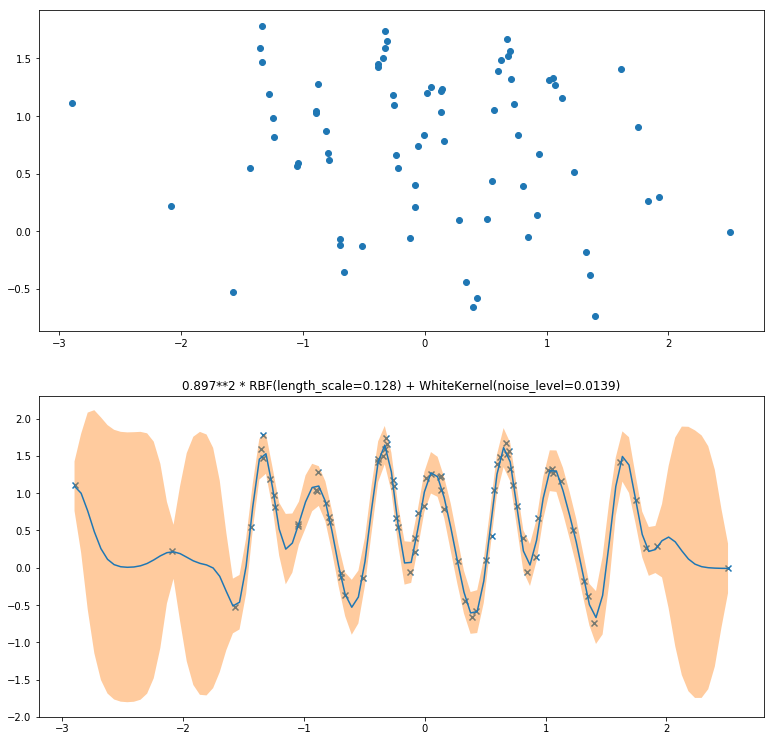

In [4]:
# To import a .mat file from a URL:
plt.figure(figsize=(13, 13))
r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/cw1a.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']
    kernel = gen_kernel(1,  1, np.exp(-1))
    gpr = gp.GaussianProcessRegressor(kernel=kernel).fit(x, y)
    print(gpr.log_marginal_likelihood())
    
    plt.subplot(2, 1, 1)
    plt.scatter(x, y)
    
    x_pred = np.linspace(min(x), max(x), 100)
    y_pred, y_cov = gpr.predict(x_pred.reshape(100,1), return_cov=True)
    y_pred = y_pred.reshape(100,)
    y_var = np.sqrt(np.diag(y_cov))
    plt.subplot(2, 1, 2)
    plt.plot(x_pred, y_pred)
    plt.title(gpr.kernel_)
    plt.scatter(x, y, marker='x')
    plt.fill_between(x_pred.squeeze(), y_pred+2*y_var, y_pred-2*y_var, alpha=0.4)

## Question (b)

Show that by initializing the hyperparameters differently, you can ﬁnd a different local optimum for the hyperparameters. Try a range of values. Show the fit. Explain what is going on. Which fit is best, and why? 

In [125]:
plt.figure(figsize=(13, 13))

with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']
    fig = plt.figure(figsize=(15,15))

    vs = np.logspace(-3, 1, 5); σs = np.logspace(-3, 1, 5); λs = np.logspace(-3, 3, 7)

    #s= ν**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ)
    model = hyp_search(x, y,
                       kernel=gp.kernels.ExpSineSquared, 
                       noise=True,
                       kernel_initialiser=gen_kernel,
                       params=[(ν, σ, λ) for ν in vs for σ in σs for λ in λs])
    
print()

<Figure size 936x936 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

### The second and third are fitting noise (?)

,kernel,kernel_optim,marglik,model
82,0.1**2 * RBF(length_scale=100) + WhiteKernel(n...,0.897**2 * RBF(length_scale=0.128) + WhiteKern...,-11.90,"GaussianProcessRegressor(alpha=1e-10, copy_X_t..."
40,0.01**2 * RBF(length_scale=100) + WhiteKernel(...,0.696**2 * RBF(length_scale=8.04) + WhiteKerne...,-78.22,"GaussianProcessRegressor(alpha=1e-10, copy_X_t..."
36,0.01**2 * RBF(length_scale=0.01) + WhiteKernel...,0.739**2 * RBF(length_scale=9.03) + WhiteKerne...,-78.23,"GaussianProcessRegressor(alpha=1e-10, copy_X_t..."
38,0.01**2 * RBF(length_scale=1) + WhiteKernel(no...,0.744**2 * RBF(length_scale=308) + WhiteKernel...,-78.34,"GaussianProcessRegressor(alpha=1e-10, copy_X_t..."
2,0.001**2 * RBF(length_scale=0.1) + WhiteKernel...,0.00316**2 * RBF(length_scale=0.1) + WhiteKern...,-106.35,"GaussianProcessRegressor(alpha=1e-10, copy_X_t..."


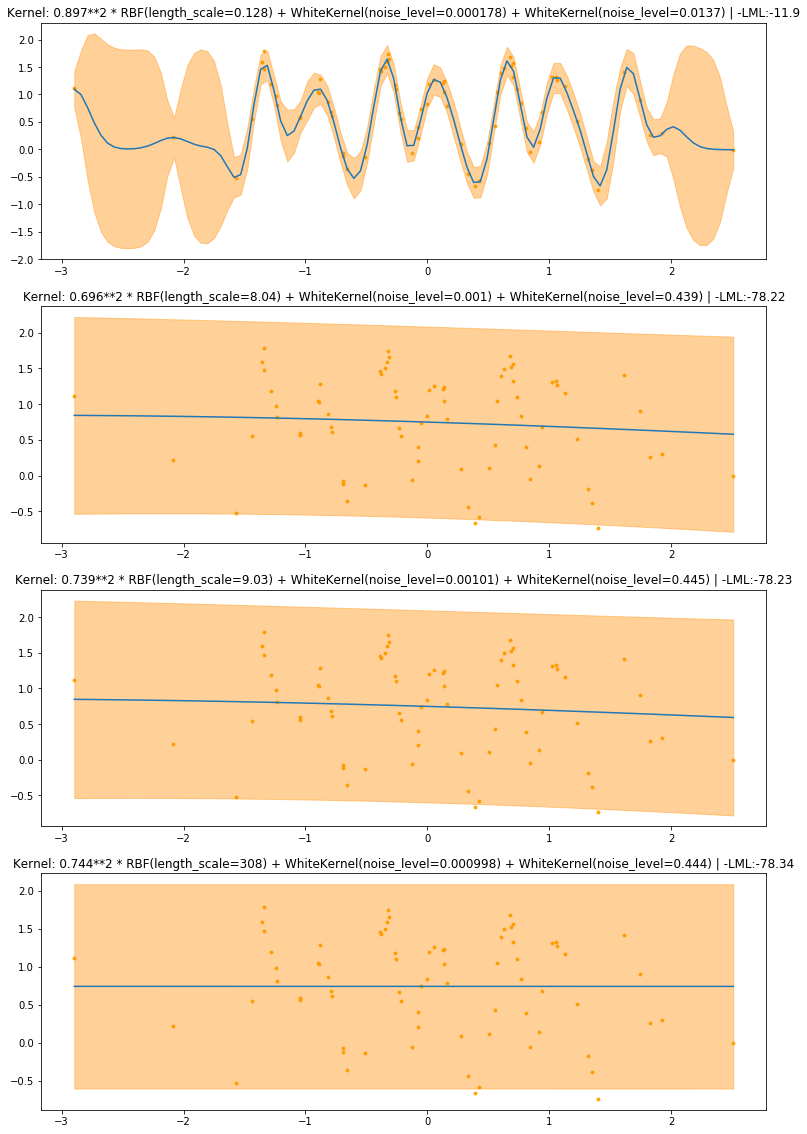

In [134]:
plt.figure(figsize=(13, 20))

results = process_results(model)
uniq = results.round({'marglik': 2})
uniq = uniq.drop_duplicates(subset='marglik')
display(uniq.head(5))

x_pred = np.linspace(min(x), max(x), 100)

plt_num = 1
plt_tot = 4

for (i, row) in uniq.head(plt_tot).iterrows():
    y_pred, y_cov = row.model.predict(x_pred.reshape(100,1), return_cov=True)
    y_pred = y_pred.reshape(100,)
    y_var = np.sqrt(np.diag(y_cov))
    plt.subplot(plt_tot, 1, plt_num)
    plt.title(f'Kernel: {row.kernel_optim} | -LML:{row.marglik}')
    plt.scatter(x, y, c='orange',s=8)
    plt.plot(x_pred, y_pred)
    plt.fill_between(x_pred.squeeze(), y_pred+2*y_var, y_pred-2*y_var, alpha=0.4, color='darkorange')
    plt_num+=1

## Question (c)

Train instead a GP with a periodic covariance function, using [`gp.kernels.ExpSineSquared`](http://scikit-learn.org/stable/modules/gaussian_process.html#exp-sine-squared-kernel). Show the fit. Comment on the
behaviour of the error-bars, compared to your fit from (a). Do you think the data generating mechanism
was really periodic? Why, why not?

In [149]:
model = None

r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/cw1a.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']
    model = hyp_search(x, y, 
                       kernel=gp.kernels.ExpSineSquared, 
                       noise=True,
                       params=[{'length_scale': l, 'periodicity': p} for l in np.logspace(-2, 2, 15) for p in np.logspace(0, 2, 15)])

<Figure size 936x360 with 0 Axes>

,kernel_optim,marglik
105,"1.16**2 * ExpSineSquared(length_scale=1.03, pe...",35.266945
180,"1.16**2 * ExpSineSquared(length_scale=1.03, pe...",35.266945
135,"1.16**2 * ExpSineSquared(length_scale=1.03, pe...",35.266945
16,"1.16**2 * ExpSineSquared(length_scale=1.03, pe...",35.266945
136,"1.16**2 * ExpSineSquared(length_scale=1.03, pe...",35.266945


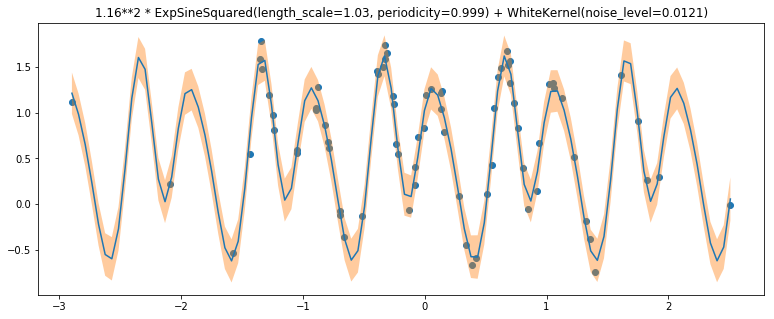

In [150]:
plt.figure(figsize=(13, 5))

modelsorted = pd.DataFrame(model).sort_values('marglik', ascending=False)
display(modelsorted[['kernel_optim','marglik']].head(5))
gpr = modelsorted.iloc[0].model

x_pred = np.linspace(min(x), max(x), 100)

y_pred, y_cov = gpr.predict(x_pred.reshape(100,1), return_cov=True)
y_pred = y_pred.reshape(100,)
y_var = np.sqrt(np.diag(y_cov))
plt.scatter(x, y)
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred[:,0], y_pred+ 1.96*y_var, y_pred- 1.96*y_var, alpha=0.4)
plt.title(gpr.kernel_)
print()

In [148]:
print(np.logspace(-10, 2, 10))

[1.00000000e-10 2.15443469e-09 4.64158883e-08 1.00000000e-06
 2.15443469e-05 4.64158883e-04 1.00000000e-02 2.15443469e-01
 4.64158883e+00 1.00000000e+02]


## Question (d)

Generate 200 noise-free data points at `x = np.linspace(-5,5,200)` from a Gaussian process with the following
covariance function: 
```
1 * gp.kernels.ExpSineSquared(length_scale=np.exp(-0.5), periodicity=1) 
    * gp.kernels.RBF(length_scale=np.exp(2)))
```
Don’t add noise to the function values, i.e. don't add `gp.kernels.WhiteKernel()` to the kernel.
Using `GaussianProcessRegressor.sample_y()`, plot some sample functions. Explain their behaviour.

_The choice of kernel dictates what output are likely. By looking at sample functions, 
you gain experience of the expressive power of Gaussian process models. Ultimately, you should be able to look at a scatterplot and
know straight away what type of kernel would be a good fit._

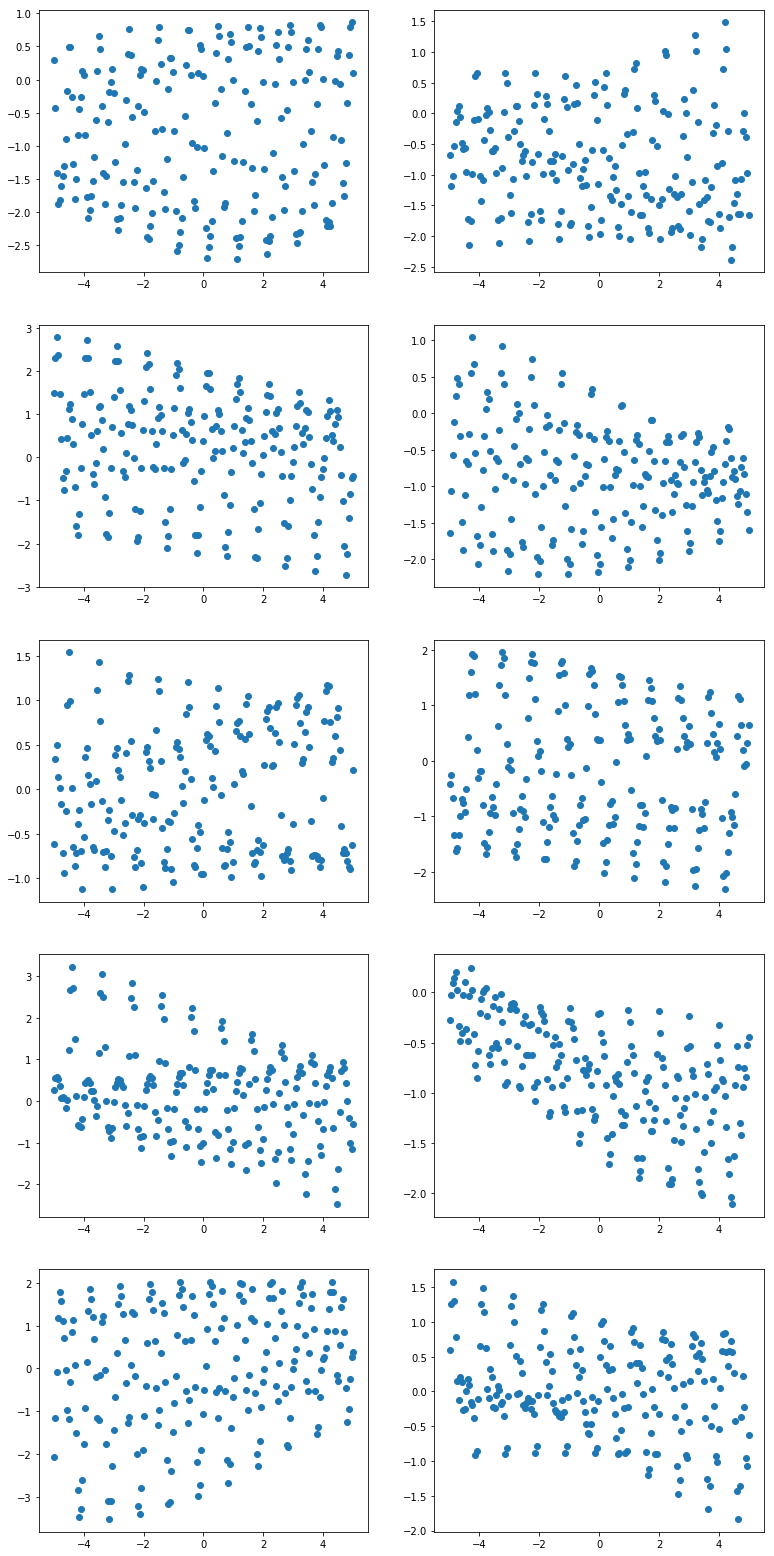

In [54]:
plt.figure(figsize=(13,28))

kernel = 1 * gp.kernels.ExpSineSquared(length_scale=np.exp(-0.5), periodicity=1) * gp.kernels.RBF(length_scale=np.exp(2))
x = np.linspace(-5,5,200)
gpr = gp.GaussianProcessRegressor(kernel=kernel)

for i in range(10):
    y = gpr.sample_y(x.reshape(-1, 1), random_state=i)
    plt.subplot(5, 2, i+1)
    plt.scatter(x, y)


## Question (e)

Load `https://teachingfiles.blob.core.windows.net/probml/cw1e.mat`. This data has two-dimensional input and scalar output. Visualise the data, e.g. using the code snippets in the appendix.
Consider two different Gaussian process models of the data, one using covariance function
`RBF(length_scale=[l1,l2])`
and the other using the sum of two such `RBF` terms. (Make sure to break symmetry, e.g. by choosing the initial hyperparameters randomly.)

Compare the two models. How do the data fits compare? How do the marginal likelihoods compare? What is your interpretation? Which of the two is better?

> When `length_scale` is a list, the `RBF` kernel uses separate length-scale parameters for each dimension of the input space. In GPML it is known as 'Squared Exponential with Automatic Relevance Determination', `covSEard`. It is a useful tool to learn which inputs are important for predictions: if length-scales are short, inputs are very important, and when they grow very long (compared to the spread of the data), the corresponding inputs will be largely ignored.

(121, 2) eee


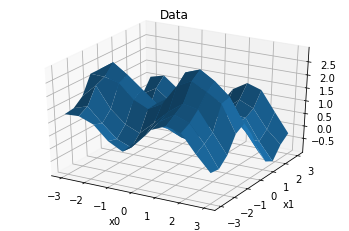

GPR marg likelihood: -204.13215194685705


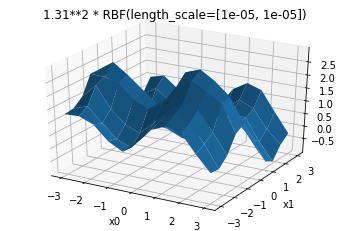

GPR marg likelihood: -127.85467588943226


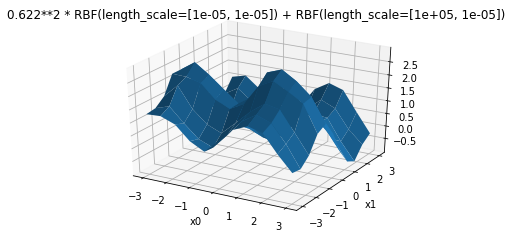

In [175]:
from mpl_toolkits.mplot3d import axes3d   # import a library to allow 3d plots


l1, l2 = np.random.uniform(0, 100, 2)
l3, l4 = np.random.uniform(0, 100, 2)
kernel1 = 1 * gp.kernels.RBF(length_scale=[l1, l2])
kernel2 = 1 * (gp.kernels.RBF(length_scale=[l1, l2]) + gp.kernels.RBF(length_scale=[l3, l4]))

r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/cw1e.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']
    X = x[:,0].reshape((11,11))
    Y = x[:,1].reshape((11,11))
    Z = y.reshape((11,11))
    axes = plt.figure().gca(projection='3d')
    axes.plot_surface(X, Y, Z)
    axes.set_xlabel('x0')
    axes.set_ylabel('x1')
    axes.set_title('Data')
    plt.show()
    
    gpr1 = gp.GaussianProcessRegressor(kernel=kernel1)
    gpr1.fit(x, y)
    y_pred1 = gpr1.predict(x)
    #print(f'GPR1 marg likelihood: {gpr1.log_marginal_likelihood()}')
    gpr2 = gp.GaussianProcessRegressor(kernel=kernel2)
    gpr2.fit(x, y)
    y_pred2 = gpr1.predict(x)

    for (gpr, y_pred) in [(gpr1, y_pred1), (gpr2, y_pred2)]:
        X = x[:,0].reshape((11,11))
        Y = x[:,1].reshape((11,11))
        Z = y_pred.reshape((11,11))
        
        print(f'GPR marg likelihood: {gpr.log_marginal_likelihood()}')

        axes = plt.figure().gca(projection='3d')
        axes.plot_surface(X, Y, Z)
        axes.set_xlabel('x0')
        axes.set_ylabel('x1')
        axes.set_title(gpr.kernel_)
        plt.show()


## Question (f)

Load `https://teachingfiles.blob.core.windows.net/probml/twoseries.csv`. This data consists of two time series, where $t$ is time, $k$ is the index of the series, and $y$ is the output. 
The data has two-dimensional input, but the second dimension is categorical rather than numerical, so it doesn't make sense to use the RBF kernel. Instead,
consider the model
$$
Y_{t,k} = Z_t + E_k + \operatorname{Normal}(0,\sigma^2)
$$
where $Z_t$ is a shared underlying RBF Gaussian process, and $E_1$ and $E_2$ are independent $\operatorname{Normal}(0,\rho^2)$ offsets, giving
$$
\operatorname{Cov}(Y_{t,k}, Y_{t',k'}) = \nu^2 \exp \Bigl( -\frac{(t-t')^2}{2\ell^2}\Bigr) + \rho^2 \delta_{k k'} + \sigma^2 \delta_{t t'}\delta_{k k'}.
$$
Implement a kernel for this model, fit it, and plot your predicted values for the two time series.

In [285]:
from scipy.spatial.distance import cdist  # cdist(X,Y, metric=...) returns a matrix M_{i,j} = dist(X[i], Y[j])
from sklearn.gaussian_process.kernels import Hyperparameter

class SpecificRBF(gp.kernels.Kernel):
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds
        
    @property
    def hyperparameter_length_scale(self):
        # return Hyperparameter(name, type, bounds, num.dimensions).
        # The Hyperparameter class also has a property .fixed.
        return gp.kernels.Hyperparameter("length_scale", 'numeric', self.length_scale_bounds, 1)

    def is_stationary(self):
        return True
    
    def diag(self, X):
        # The code, as originally posted, returned self(X,X), which is incorrect.
        return np.diagonal(self(X, X))

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y) if Y is not None else X

        if X.ndim != 2 or Y.ndim != 2 or X.shape[1] != 2 or Y.shape[1] != 2:
            raise ValueError("Features must be 2-dimensional")
        length_scale = np.squeeze(self.length_scale).astype(float)
        if length_scale.ndim != 0:
            raise ValueError("Length scale must be a number")

        t_1 = X[:, 0].reshape(-1, 1)
        t_2 = Y[:, 0].reshape(-1, 1)
        
        K = np.exp(-0.5 * cdist(t_1, t_2, metric='sqeuclidean') / length_scale**2)
        print(K.shape)
        if not eval_gradient:
            return K

        # The gradient is with respect to log-transformed parameters.
        # I.e. if length_scale=exp(x), then eval_gradient should return d/dx.
        # If there are multiple hyperparameters, return an array with one
        # column for each non-fixed hyperparameter, sorted alphabetically
        # by hyperparameter name.
        if self.hyperparameter_length_scale.fixed:
            K_gradient = np.empty((len(t_1), len(t_2), 0))
        else:

            K_gradient = K * cdist(t_1, t_2, metric='sqeuclidean') / length_scale**2

        return K, K_gradient[:, :, np.newaxis]

    def __repr__(self):
        return f"SpecificRBF(length_scale={self.length_scale:.3g})"

In [300]:
from scipy.spatial.distance import cdist  # cdist(X,Y, metric=...) returns a matrix M_{i,j} = dist(X[i], Y[j])
from sklearn.gaussian_process.kernels import Hyperparameter

class SpecificDelta(gp.kernels.Kernel):
    def __init__(self, index=0):
        self.index = index
        
    def is_stationary(self):
        return True
    
    def diag(self, X):
        # The code, as originally posted, returned self(X,X), which is incorrect.
        return np.diagonal(self(X, X))

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y) if Y is not None else X

        if X.ndim != 2 or Y.ndim != 2 or X.shape[1] != 2 or Y.shape[1] != 2:
            raise ValueError("Features must be 2-dimensional")

        k_1 = X[:, self.index]
        k_2 = Y[:, self.index]

        noise_term_k = np.eye(k_1.shape[0])
        
        K = noise_term_k

        if not eval_gradient:
            return K

        #if self.hyperparameter_noise_level_k.fixed:
        K_gradient = np.empty((len(k_1), len(k_2), 0))
        #else:
        #    K_gradient = noise_term_k

        return K, K_gradient#[:, :, np.newaxis]

    def __repr__(self):
        return f"SpecificDelta({self.index})"

(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
-196.51690662173735
(100, 100)


Text(0.5, 1.0, 'SpecificRBF(length_scale=5.41) + 1.19**2 * SpecificDelta(1) + 1.19**2 * SpecificDelta(0) * SpecificDelta(1)')

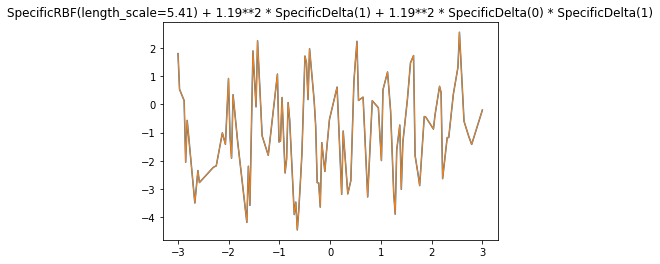

In [301]:
twoseries = pd.read_csv('https://raw.githubusercontent.com/damonjw/probml/master/data/twoseries.csv')
t,k,y = twoseries['t'].values, twoseries['k'].values, twoseries['y'].values

C = gp.kernels.ConstantKernel

X = np.c_[t,k]
kernel = SpecificRBF() + C() * SpecificDelta(index=1) + C() * SpecificDelta(index=0) * SpecificDelta(index=1)
gpr = gp.GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y)
print(gpr.log_marginal_likelihood())

plt.plot(t, y)
plt.plot(t, gpr.predict(X), linewidth=1)
plt.title(gpr.kernel_)

<div style="height: 15em"></div>

# Appendix

## Gaussian processes in Python

Here is a simple example of how to use `sklearn.gaussian_process`. For full details, see the [documentation](http://scikit-learn.org/stable/modules/gaussian_process.html).

Let's consider a simple Gaussian process model: a prior on the space of Gaussian processes, with mean 0, and with covariance function
$$
k(x, x') = \nu^2 \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr)
$$
(this function is called `RBF` in `sklearn.gaussian_process` and `covSEiso` in GPML). Suppose that the data model is  
$$
p(y\:|\:x,f) \sim
\operatorname{Normal}\bigl(f(x), \sigma^2 I\bigr)
$$
where $x$ and $y$ are vectors and $f(x)$ means $(f(x_1),\dots,f(x_n))$. In this model, $\nu$, $\ell$ and $\sigma$ are hyperparameters. Another way to write out this entire model is with a single covariance function,
$$
k(x, x') = \nu^2 \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr) + \sigma^2 \delta_{x x'}.
$$

In the `gaussian_process` package, a Gaussian process model is specified by a _kernel_ object. (Kernel is another name for covariance function.) The package has a [library of kernels](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels), each implemented as a Python class, and we can create composite kernels by adding together and multiplying kernel objects.

In [4]:
l = np.exp(-1)
ν = 0.5
σ = 1
kernel1 = ν**2 * gp.kernels.RBF(length_scale=l) + gp.kernels.WhiteKernel(noise_level=σ)
kernel1

0.5**2 * RBF(length_scale=0.368) + WhiteKernel(noise_level=1)

To extract parameters from a kernel, use `get_params()`. You can also use `set_params` to set the parameters for a kernel.

In [5]:
kernel1.get_params()

{'k1': 0.5**2 * RBF(length_scale=0.368),
 'k1__k1': 0.5**2,
 'k1__k1__constant_value': 0.25,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2': RBF(length_scale=0.368),
 'k1__k2__length_scale': 0.36787944117144233,
 'k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k2': WhiteKernel(noise_level=1),
 'k2__noise_level': 1,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

Machine learning functions are implemented via the class `GaussianProcessRegressor`, which is initialized with a kernel object. It has methods for learning hyperparameters and making predictions. We can access a model's kernel with `GaussianProcessRegressor.kernel`.

In [6]:
model1 = gp.GaussianProcessRegressor(kernel=kernel1)
model1.kernel

0.5**2 * RBF(length_scale=0.368) + WhiteKernel(noise_level=1)

To learn hyperparameters, use `GaussianProcessRegressor.fit(x,y)`. It requires the parameters to be arrays with one row per observation. In the example below we start with one-dimensional input and output, so we have to reshape them to be column vectors. We can access the fitted kernel, and thence the fitted parameters, with `model.kernel_`.

In [7]:
# Training data
x = np.array([0.57650, 0.43504, 0.76607, -0.78369, -1.27129, -0.66034, 1.18100, 
              0.25929, 0.50898, -0.73703, 0.83023, 1.60078, -0.34655, -0.68073, 
              -1.21480, -0.55955, -1.28229, 0.85388, 0.73265, -0.75330])
y = np.array([ 0.96948, 1.08384, 0.62050, -0.65940, 0.54944, -0.88911, -0.37886,
              0.77166, 0.97753, -0.75901, 0.76003, -1.13327, -0.74600, -0.99293,
              0.60169, -0.98088, 0.55333, 0.60247, 0.99501, -0.83345])

model1.fit(x[..., np.newaxis], y[..., np.newaxis])
model1.kernel_

0.901**2 * RBF(length_scale=0.53) + WhiteKernel(noise_level=0.00852)

To make predictions with a fitted model, call `GaussianProcessRegressor.predict(x)`. As before, `x` should be a column vector.

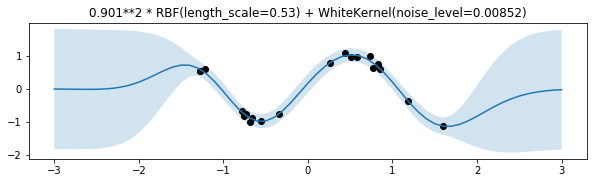

In [8]:
# New values of x where we want to make a prediction
newx = np.linspace(-3, 3, 61)
μ,σ = model1.predict(newx[..., np.newaxis], return_std=True)

# Plot the output.
# squeeze() is a numpy function that turns column vectors into simple 1d vectors.
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.fill_between(newx, μ.squeeze()-2*σ, μ.squeeze()+2*σ, alpha=.2)
    plt.plot(newx, μ.squeeze())
    plt.scatter(x, y, color='black')
    plt.title(model1.kernel_)
plt.show()

## Custom kernels

If there is no standard kernel that captures the covariance function we want, it's easy to implement a custom kernel. 
Below is a reimplementation of the RBF kernel, which has covariance function
$$
k(x, x') = \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr).
$$
The main method is `__call__`, which computes a covariance matrix, 
and is invoked by
```
k = MyRBFKernel(length_scale=2.718)
x = np.array([1,2,4])[:, np.newaxis]
y = np.array([1.5,3])[:, np.newaxis]
k(x,y)     # returns a matrix m_{i,j} = kernel(x_i, y_j)
```
The `__init__` constructor should accept arguments for each hyperparameter,
and there should be `hyperparameter_X` properties that describe each hyperparameter.
The simple implementation below requires $x\in\mathbb{R}$, but the [source code for the built-in RBF kernel](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/gaussian_process/kernels.py) allows multidimensional features $x\in\mathbb{R}^d$ with anisotropic length-scale $\ell\in\mathbb{R}^d$.
It is also more efficient.

In [9]:
from scipy.spatial.distance import cdist  # cdist(X,Y, metric=...) returns a matrix M_{i,j} = dist(X[i], Y[j])

class MyRBFKernel(gp.kernels.Kernel):
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds

    @property
    def hyperparameter_length_scale(self):
        # return Hyperparameter(name, type, bounds, num.dimensions).
        # The Hyperparameter class also has a property .fixed.
        return gp.kernels.Hyperparameter("length_scale", 'numeric', self.length_scale_bounds, 1)

    def is_stationary(self):
        return True
    
    def diag(self, X):
        # The code, as originally posted, returned self(X,X), which is incorrect.
        return np.diagonal(self(X, X))

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y) if Y is not None else X
        if X.ndim != 2 or Y.ndim != 2 or X.shape[1] != 1 or Y.shape[1] != 1:
            raise ValueError("Features must be scalars")
        length_scale = np.squeeze(self.length_scale).astype(float)
        if length_scale.ndim != 0:
            raise ValueError("Length scale must be a number")
        
        K = np.exp(-0.5 * cdist(X, Y, metric='sqeuclidean') / length_scale**2)
        
        if not eval_gradient:
            return K

        # The gradient is with respect to log-transformed parameters.
        # I.e. if length_scale=exp(x), then eval_gradient should return d/dx.
        # If there are multiple hyperparameters, return an array with one
        # column for each non-fixed hyperparameter, sorted alphabetically
        # by hyperparameter name.
        if self.hyperparameter_length_scale.fixed:
            K_gradient = np.empty((len(X), len(Y), 0))
        else:
            K_gradient = K * cdist(X, Y, metric='sqeuclidean') / length_scale**2
        return K, K_gradient[:, :, np.newaxis]

    def __repr__(self):
        return f"RBF(length_scale={self.length_scale:.3g})"

## Plotting a function of two variables

Here are some ways we might plot the data from part (e).

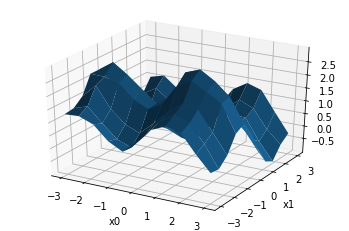

In [12]:
from mpl_toolkits.mplot3d import axes3d   # import a library to allow 3d plots

# Reshape the data to be in array form
X = x[:,0].reshape((11,11))
Y = x[:,1].reshape((11,11))
Z = y.reshape((11,11))

# Optionally: use `%matplotlib notebook` to make the plots interactive.
# Get axes for a 3d plot, and then plot the surface
axes = plt.figure().gca(projection='3d')
axes.plot_surface(X, Y, Z)
axes.set_xlabel('x0')
axes.set_ylabel('x1')
plt.show()

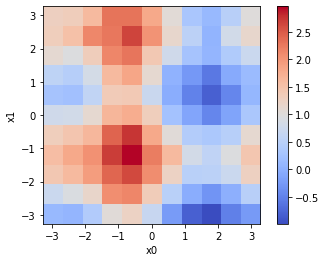

In [13]:
# A heatmap
plt.imshow(y.reshape((11,11)), extent=np.array([-3,3,-3,3])*12/11, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('x0')
plt.ylabel('x1')
plt.colorbar()
plt.show()